In [1]:
import pandas as pd
import os
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
%%time
# collect walmart
years = list(range(2010,2021)) # this gets years from 2010 to 2020
files = consolidate_files(years)
walmart = filenames_to_para(files)
walmart["company"] = "Walmart"

# collect data from competitors
competitors = ["Amazon", "Costco", "Target", "Kroger"]
df_competitors = pd.DataFrame()
for competitor in competitors:
    files_tmp = consolidate_files_others(competitor)
    df_tmp = filenames_to_para(files_tmp)
    df_tmp["company"] = competitor
    df_competitors = pd.concat([df_competitors, df_tmp], ignore_index=True)

# concat walmart and competitors
df = pd.concat([walmart, df_competitors], ignore_index=True)

# # save data
# df.to_csv("Paragraphs_all.csv", index=False)

# replace "WRAPTEXT"
df["paragraph"] = df["paragraph"].map(lambda x: x.replace("WRAPTEXT", ''))

Wall time: 2min 4s


## Preprocessing

In [4]:
%%time
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

## filter out rows containing too few words/tokens
df["len_clean"] = df["tokens_clean"].map(len)
df = df[df["len_clean"]>10]

# removing disclaimer
df = df[df["paragraph"].map(lambda x: "The information in the transcripts" not in x)]
df = df[df["paragraph"].map(lambda x: "disclaimer" not in x.lower())]
df = df[df["paragraph"].map(lambda x: "forward-looking statements" not in x.lower())]


# removing some paragraphs
removing_words = ["www.streetevents.com"]
mask = df["tokens_clean"].map(lambda x: removing_words[0] not in x)
df = df[mask]

Wall time: 1min 34s


## Load dictionary

In [196]:
import gensim
dictionary = gensim.models.word2vec.Word2Vec.load("capstone_dictionary.model")

In [14]:
# check the result
word = 'employee'
dictionary.wv.most_similar(positive=word, topn=10)

[('associate', 0.5780292749404907),
 ('agreement', 0.5143362879753113),
 ('protected', 0.48922455310821533),
 ('accrual', 0.4678422808647156),
 ('equity', 0.4583693742752075),
 ('approve', 0.4552827775478363),
 ('receivable', 0.45438098907470703),
 ('catcher', 0.45233097672462463),
 ('retirement', 0.44866833090782166),
 ('amendment', 0.44488590955734253)]

In [203]:
# check the result
word = 'customer'
dictionary.wv.most_similar(positive=word, topn=10)

[('guest', 0.7368943095207214),
 ('customers', 0.5565394163131714),
 ('user', 0.5473891496658325),
 ('member', 0.5235416293144226),
 ('guests', 0.5000215768814087),
 ('consumers', 0.4689869284629822),
 ('subscriber', 0.45255839824676514),
 ('seamless', 0.4299562871456146),
 ('shopper', 0.4166208505630493),
 ('consumer', 0.41648435592651367)]

In [204]:
# check the result
word = 'item'
dictionary.wv.most_similar(positive=word, topn=10)

[('items', 0.5108912587165833),
 ('column', 0.4192255139350891),
 ('element', 0.4119713306427002),
 ('calculation', 0.407062828540802),
 ('piece', 0.4040316343307495),
 ('person', 0.39611750841140747),
 ('varietals', 0.38605526089668274),
 ('component', 0.38236933946609497),
 ('intangibles', 0.3805769085884094),
 ('location', 0.38004636764526367)]

In [25]:
from collections import Counter
import itertools

# count most frequent words
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count = Counter(list(itertools.chain.from_iterable(df["corpus"].map(lambda x: x.split(',')))))

# print the most similar word for the most frequent words
for word in count.most_common(500):
    try:
        result = dictionary.wv.most_similar(positive=word[0].strip(), topn=1)
        if result[0][1] > 0.55:
            print(word[0], result)
    except:
        print("====")

 year [('quarter', 0.5933531522750854)]
 quarter [('year', 0.5933531522750854)]
====
 sale [('vips', 0.5646840929985046)]
 think [('know', 0.5582809448242188)]
 continue [('continued', 0.6401090621948242)]
 customer [('guest', 0.7368943095207214)]
 business [('businesses', 0.5767821669578552)]
 see [('show', 0.5722830891609192)]
 get [('bring', 0.5691134333610535)]
 increase [('decline', 0.6856720447540283)]
 basis [('bases', 0.660706639289856)]
 make [('making', 0.6899864673614502)]
 price [('pricing', 0.6133900880813599)]
 lot [('lots', 0.7403498888015747)]
 share [('se', 0.581145167350769)]
 look [('looked', 0.6596668362617493)]
 margin [('margins', 0.7543666362762451)]
 rate [('rates', 0.6062857508659363)]
 know [('think', 0.5582809448242188)]
 term [('haul', 0.6778750419616699)]
 want [('need', 0.680665135383606)]
 investment [('investments', 0.6525512337684631)]
 say [('assume', 0.6488872170448303)]
 team [('teams', 0.6056873202323914)]
 go [('move', 0.6219207048416138)]
 impact 

In [17]:
# the number of unique words after pre-processing
len(count)

9857

In [13]:
# ## output data for training dictionary
# df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
# df.head()
# df[["paragraph", "date", "company", "corpus"]].to_csv("Paragraphs_all.csv")

In [2]:
# df = pd.read_csv("Paragraphs_all.csv", parse_dates=["date"])

## Preprocessing second-phase

**Replacement of words**
- use a heuristic approach, whenever we see a strange word, we will come back, run the dictionary and see if it makes sense to replace such word
- an alternative to heuristic is to replace the most frequent words with their most similar words, but some problem can occur, e.g. it replaces "increasing" with "decling"

In [38]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [247]:
df = df[df["paragraph"].map(lambda x: "forward-looking statements" not in x.lower())]

# removing some words
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning", 
    "company", "mean", "wraptext", "”", '’', "thanks", "term", "basis",
    "grow", "growth", "call", "people", "point", "sale", "percent",
    "continue", "comp", "share", "result", "guidance", "expect",
    "rate", "range", "earnings", "report", "end", "change", "comment",
    "item", "put", "part", "day", "unit", "exchange", "week", "number",
    "something", "statement", "release", "press", "meeting", "include",
    "open", "start", "saw", "mention", "feel", "add", "give", "sort", # after open
    "like", "stuff", "ask", "month", "today", "com", "president",
    "calendar", "line", "believe", "use", "compare"
]

df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

# removing short paragraphs
df = df[df.len_clean > 22]

# prepare count vector as the input of LDA model
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))

# replace "employee" with "associate"
df["corpus"] = df["corpus"].map(lambda x: x.replace("employee", "associate"))
# replace "guest" with "customer"
df["corpus"] = df["corpus"].map(lambda x: x.replace("guest", "customer"))


In [248]:
def replace_in_list(lis, old, new):
    for i in range(len(lis)):
        if lis[i] == old:
            lis[i] = new
    return(lis)
df["tokens_clean"] = df["tokens_clean"].map(lambda x: replace_in_list(x, "employee", "associate"))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: replace_in_list(x, "guest", "customer"))

## Modeling with gensim and calculating coherence
code reference: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

explanation of coherence score: https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense

other reference, different ways to calculate coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [249]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(df["tokens_clean"])
corpus = [dictionary.doc2bow(doc) for doc in df["tokens_clean"]]

id2word = dictionary.id2token

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, coherence='c_v'):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

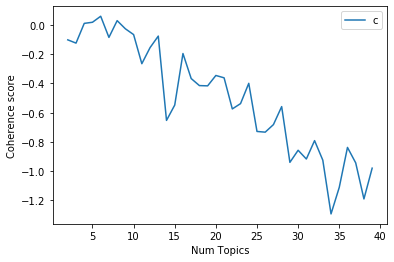

Wall time: 13min 16s


In [246]:
%%time

docs = df["tokens_clean"]

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, 
                                                        start=2, limit=40, step=1, coherence='c_uci')
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## C_v coherence

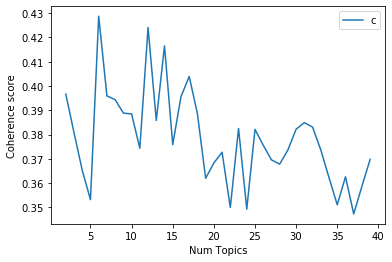

Wall time: 13min 29s


In [250]:
%%time

docs = df["tokens_clean"]

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [251]:
pd.Series(coherence_values, index=x).sort_values(ascending=False)

6     0.428701
12    0.424064
14    0.416480
17    0.403931
2     0.396638
7     0.395915
16    0.395571
8     0.394363
9     0.388831
18    0.388622
10    0.388468
13    0.385796
31    0.384921
32    0.383069
23    0.382500
30    0.382203
25    0.382143
3     0.380755
15    0.375863
26    0.375621
11    0.374359
33    0.373665
29    0.373659
21    0.372726
39    0.369797
27    0.369578
20    0.368296
28    0.367828
4     0.365294
36    0.362609
34    0.362211
19    0.362001
38    0.358711
5     0.353210
35    0.351095
22    0.350000
24    0.349294
37    0.347329
dtype: float64

## Topic modeling

In [252]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 12

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =0)
lda.fit(count_data)
       
number_words = 6
# print_topics(lda, count_vectorizer, number_words)

words = count_vectorizer.get_feature_names()

# print topics and key words
for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic + 1, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 1  ====================
margin          5.67%
gas             2.96%
impact          2.03%
benefit         1.43%
card            1.23%
core            1.10%
couple          1.09%
penetration      1.05%
come            1.04%
credit          0.95%
topic: 2  ====================
member         10.03%
membership      4.31%
club            2.90%
sign            1.72%
fee             1.64%
card            1.43%
renewal         1.30%
website         1.25%
information      1.09%
discussion      0.98%
topic: 3  ====================
market          2.53%
increase        2.19%
price           1.67%
drive           1.51%
expense         1.32%
traffic         1.27%
deliver         1.24%
performance      1.15%
income          1.14%
focus           1.10%
topic: 4  ====================
category        3.46%
brand           2.22%
holiday         1.76%
season          1.64%
assortment      1.53%
traffic         1.38%
apparel         1.34%
product         1.24%
home            1.13%
performance    

## Visualize topic distribution

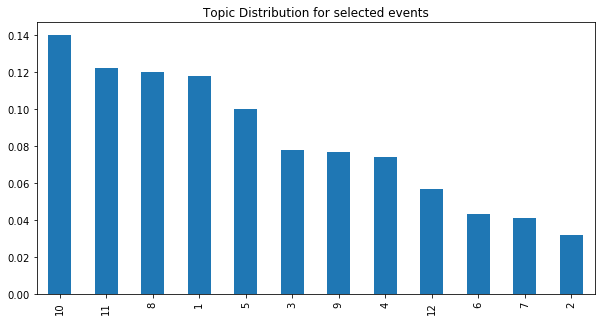

In [253]:
# assign topic to paragraphs
topic_match = lda.transform(count_data)
df["topic"] = [ x.argsort()[-1] + 1 for x in topic_match]

# # chech how many topics in each paragraphs
# df["number of topics"] = [sum(x>x.mean()) for x in topic_match]

topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

### deal with multi topics

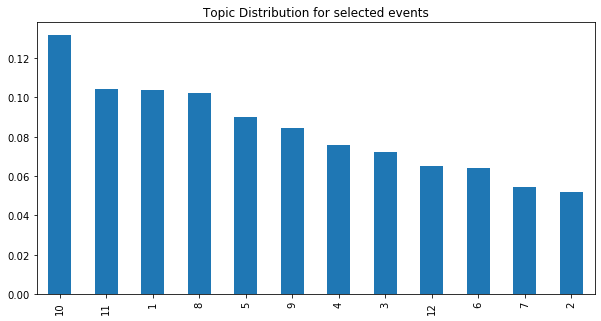

In [254]:
def get_multi_topics(lis):
    lis = pd.Series(lis)
    output = lis[lis > np.mean(lis)].index.values
    return(output)

df["multi_topics"] = [ get_multi_topics(x) for x in topic_match]


dff = pd.DataFrame()
for i in df.index:
    topics = df.loc[i, "multi_topics"]
    tmp = df.loc[i:i, ["paragraph", "date", "year", "company"]]
    for j in range(len(topics)):
        tmp["topic"] = topics[j] + 1
        dff = pd.concat([dff, tmp], ignore_index=True)

topic_counts = dff["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

## Visualize paragraph counts for each year

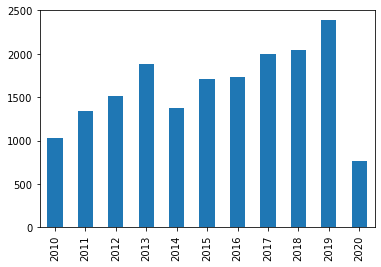

In [255]:
# df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
dff['year'] = pd.PeriodIndex(dff.date, freq='Y')
dff["year"].value_counts().sort_index().plot(kind='bar')

## Topic trends

In [256]:
companies = dff.company.drop_duplicates()
ct_dic = dict()
for company in companies:
    tmp_dff = dff[dff["company"]==company]
    ct_dic[company] = pd.crosstab(tmp_dff["year"],tmp_dff["topic"], normalize="index")

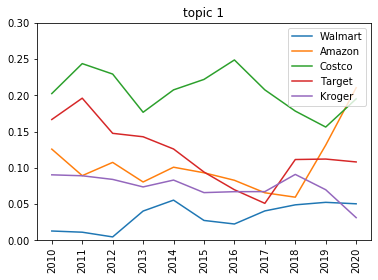

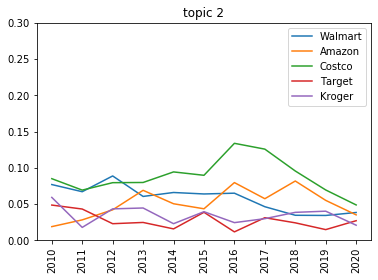

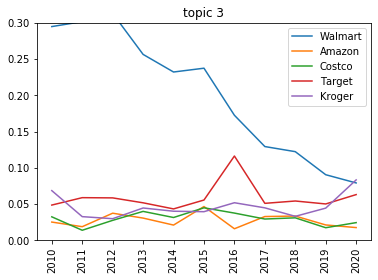

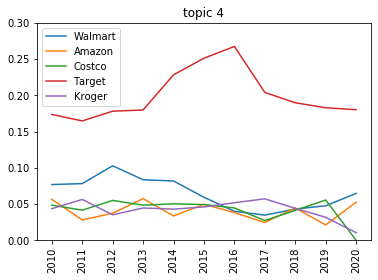

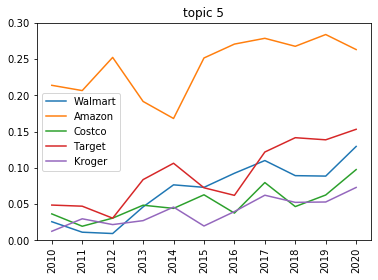

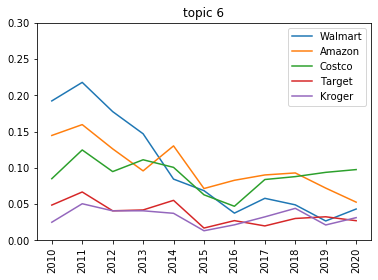

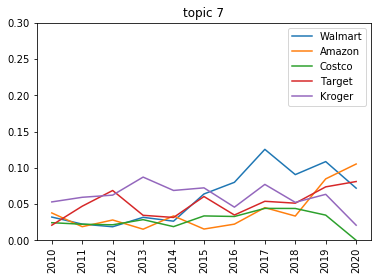

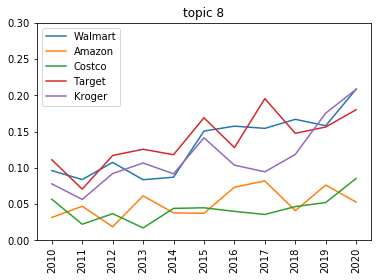

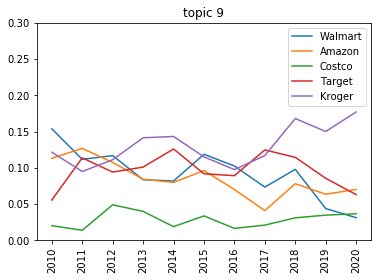

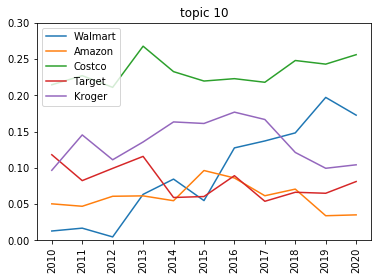

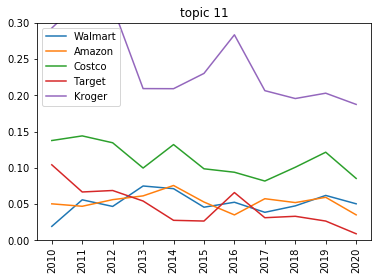

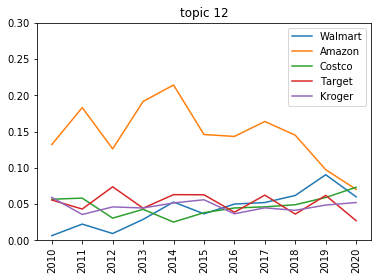

In [257]:
for topic in range(1,number_topics+1):
    
    fig, ax = plt.subplots()
    for company in companies:
        plt.plot(years, ct_dic[company][topic].values, label=company)
    ax.legend()
    plt.ylim(0, 0.3)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))
    plt.show()

## Overall trends

In [258]:
tmp = pd.crosstab(df["year"], df["topic"], normalize="index")
years = [ str(x) for x in tmp.index]

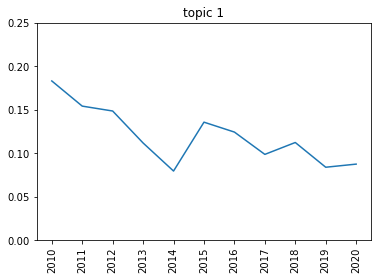

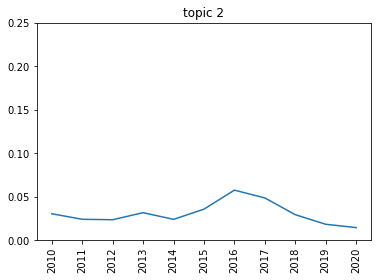

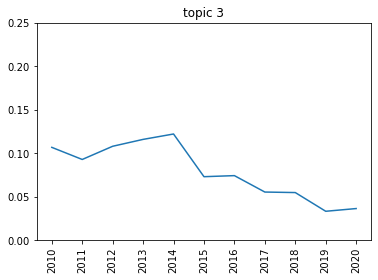

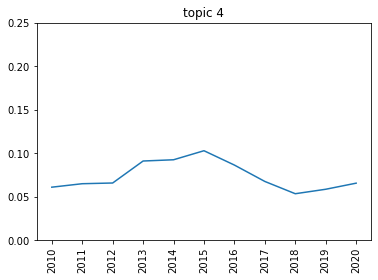

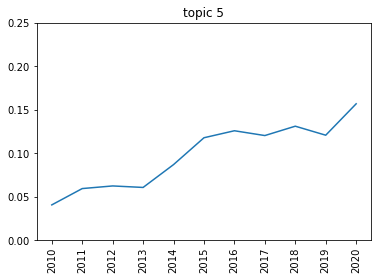

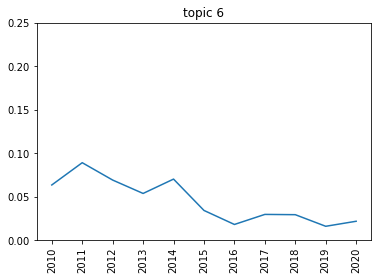

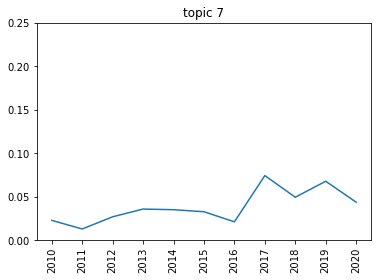

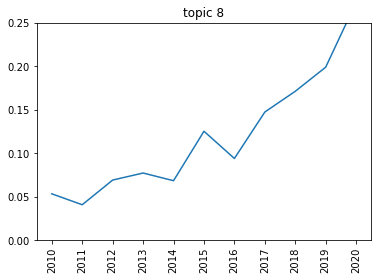

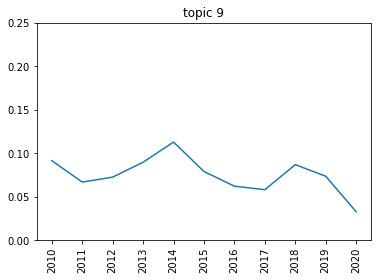

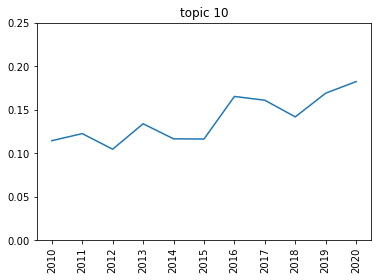

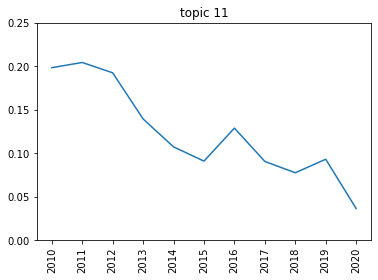

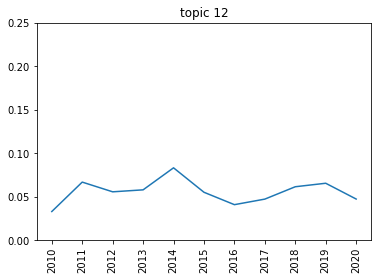

In [259]:
for topic in tmp:
    
    fig, ax = plt.subplots()
    plt.plot(years, tmp[topic].values)
    plt.ylim(0, 0.25)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

#### Checking the content

In [ ]:
check = df[df["topic"]==11]
check[check["year"] == 2017]["paragraph"].iloc[0].replace("WRAPTEXT", "")

In [ ]:
## search for certain key word
keyword = "guest"
a = check[check["paragraph"].map(lambda x: keyword in x)]

In [ ]:
a["paragraph"].iloc[10].replace("WRAPTEXT", "")

## Interactive visualization

In [260]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 1min 14s


In [261]:
pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.039850 -0.123765       1        1  13.426228
7      0.151064 -0.058318       2        1  12.730884
8     -0.130373 -0.174165       3        1  11.655159
3      0.104386 -0.076692       4        1  10.277699
0     -0.145532  0.097342       5        1   8.391627
10    -0.044722  0.013907       6        1   8.151759
4      0.086444 -0.079417       7        1   8.096980
5     -0.263525 -0.043359       8        1   8.007045
9      0.120284  0.139961       9        1   7.984631
11     0.125495  0.056925      10        1   3.879699
6      0.167405  0.026390      11        1   3.763075
1     -0.131075  0.221191      12        1   3.635214, topic_info=     Category         Freq         Term        Total  loglift  logprob
4144  Default  1643.000000       member  1643.000000  30.0000  30.0000
796   Default  2023.000000        brand  2023.000000  29.0000  29.0000
4057  Default  2775.000000       margin  2775.000000  28.0000  28.0000
3421  Default  1810.000000       income  1810.000000  27.0000  27.0000
3427  Default  3947.000000     increase  3947.000000  26.0000  26.0000
5107  Default  3156.000000        price  3156.000000  25.0000  25.0000
4146  Default   757.000000   membership   757.000000  24.0000  24.0000
2521  Default  1918.000000      expense  1918.000000  23.0000  23.0000
5151  Default  1786.000000      product  1786.000000  22.0000  22.0000
2918  Default   911.000000          gas   911.000000  21.0000  21.0000
972   Default  1034.000000      capital  1034.000000  20.0000  20.0000
6764  Default   979.000000          tax   979.000000  19.0000  19.0000
3362  Default  2053.000000       impact  2053.000000  18.0000  18.0000
2864  Default  1254.000000         fuel  1254.000000  17.0000  17.0000
6775  Default  2533.000000         team  2533.000000  16.0000  16.0000
1029  Default  2239.000000     category  2239.000000  15.0000  15.0000
1551  Default  2225.000000         cost  2225.000000  14.0000  14.0000
3475  Default  1048.000000    inflation  1048.000000  13.0000  13.0000
1662  Default   804.000000     currency   804.000000  12.0000  12.0000
1215  Default   567.000000         club   567.000000  11.0000  11.0000
2870  Default   702.000000  fulfillment   702.000000  10.0000  10.0000
1806  Default   806.000000     delivery   806.000000   9.0000   9.0000
427   Default  1621.000000    associate  1621.000000   8.0000   8.0000
1008  Default   836.000000         cash   836.000000   7.0000   7.0000
3611  Default  2538.000000   investment  2538.000000   6.0000   6.0000
5776  Default   897.000000      revenue   897.000000   5.0000   5.0000
3241  Default   864.000000      holiday   864.000000   4.0000   4.0000
4554  Default  1392.000000  opportunity  1392.000000   3.0000   3.0000
984   Default   621.000000         card   621.000000   2.0000   2.0000
4817  Default  1574.000000  performance  1574.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2651  Topic12    67.043987       filing   100.067579   2.9140  -5.1939
4223  Topic12    34.085594  millennials    49.660313   2.9382  -5.8704
3487  Topic12   131.060901  information   224.230992   2.7775  -4.5236
1380  Topic12    97.707256   conference   164.478961   2.7937  -4.8173
2622  Topic12   197.526674          fee   391.796595   2.6296  -4.1134
5607  Topic12   109.100594       remind   209.148805   2.6637  -4.7070
5674  Topic12    49.440516    reporting    91.358210   2.7005  -5.4985
1260  Topic12   111.975222          com   282.870107   2.3878  -4.6810
2009  Topic12   118.490690   discussion   317.377096   2.3292  -4.6244
6232  Topic12    39.053648        slide    70.015139   2.7307  -5.7343
1923  Topic12    47.312731       differ    93.376598   2.6346  -5.5425
984   Topic12   172.230056         card   621.438529   2.0313  -4.2504
5599  Topic12    79.186526       remark   202.671485   2.3747  -5.0274
2445  

## Building data for HLM

In [281]:
# building topic features

dff['quarter'] = pd.PeriodIndex(dff.date, freq='Q')

companies = dff.company.drop_duplicates()
topic_freq_dict = dict()
for company in companies:
    tmp_dff = dff[dff["company"]==company]
    topic_freq_dict[company] = pd.crosstab(tmp_dff["quarter"],tmp_dff["topic"], normalize="index")

topic_features = pd.DataFrame()
for company in companies:
    company_data = topic_freq_dict[company].reset_index()
    company_data["company"] = company
    topic_features = pd.concat([topic_features, company_data], ignore_index=True)

topic_features.head()

topic,quarter,1,2,3,4,5,6,7,8,9,10,11,12,company
0,2010Q1,0.027778,0.083333,0.305556,0.000000,0.027778,0.194444,0.111111,0.083333,0.166667,0.000000,0.000000,0.00000,Walmart
1,2010Q2,0.000000,0.076923,0.256410,0.051282,0.051282,0.179487,0.025641,0.102564,0.179487,0.025641,0.051282,0.00000,Walmart
2,2010Q3,0.023810,0.095238,0.285714,0.095238,0.023810,0.166667,0.000000,0.119048,0.142857,0.023810,0.000000,0.02381,Walmart
3,2010Q4,0.000000,0.051282,0.333333,0.153846,0.000000,0.230769,0.000000,0.076923,0.128205,0.000000,0.025641,0.00000,Walmart
4,2011Q1,0.000000,0.071429,0.309524,0.047619,0.000000,0.261905,0.023810,0.119048,0.119048,0.000000,0.023810,0.02381,Walmart


In [280]:
# building seasonal variables
seasonal_features = pd.get_dummies(topic_features["quarter"].map(lambda x: x.quarter), drop_first=True)
seasonal_features.head()

,2,3,4
0,0,0,0
1,1,0,0
2,0,1,0
3,0,0,1
4,0,0,0


In [303]:
# building y variables
companies = dff.company.drop_duplicates()
for company in companies:
    Fdata = pd.read_csv(os.getcwd() + "\\Financial" + "\\" + company + ".csv", index_col=0).T
 
    Fdata = Fdata.reset_index()
    

In [308]:
Fdata.columns[0] = 'date'

TypeError: Index does not support mutable operations